# House Prices Advanced Regression Techniques
----------

## Summary
You never knew you wanted to go to Ames, Iowa but by the end you will know more than you ever thought possible from a data set compiled by Dean De Cock. There are many cities that have open data sets on housing, like my local town of Burlington Vermont, but in this Kaggle competition we are looking to explore the possible relationship of the sale price to all the other features of a house. 

Many but not all of the features of a house share a linear relationship with the Sale Price. By filling missing values, some feature engineering and feature selection determining the Sales Price should not be that far off. In this case I tried applying Random Forest Regression, Lasso and Ridge Regressions to arrive at my final answer 

## Goal
Use the dataset after normalization, filling in missing values and adding new features with a linear regression model to predict sales prices.

## Method
There are a large number of features in this data set  and in order to create a good prediction there will have to be a fair amount of work to do in advance. Combining the train and test set will means changes only need to be done once across both data sets. We will be exploring the following steps:
* Correlation
* Feature Exploration
* Missing Values
* Data Normilization
* Feature Engineering
* Assembling dataset
* Prediction

There should be several good indicators for sale price, the challenge will be in normalization of the data and feature engineering.

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LassoLarsCV,Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale, OneHotEncoder
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Visualisation
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline

C:\Users\kefor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get csv files as a DataFrame
traindf = pd.read_csv("~/Desktop/Kaggle House Prices Advanced Regression Techniques/train.csv")
testdf = pd.read_csv("~/Desktop/Kaggle House Prices Advanced Regression Techniques/test.csv")

#traindf = pd.read_csv("../input/train.csv")
#testdf = pd.read_csv("../input/test.csv")

In [3]:
# create a single dataframe of both the training and testing data
wholedf = pd.concat([traindf,testdf])

In [4]:
wholedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [5]:
wholedf.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


## The Data
-----------
The data has a wide range of integer, float and categorical information. In the end those will end up as numeric, but not quite yet. There are a couple of groupings of different types of measurements and understanding their differences will help in determining what new features can be created.

Neighborhood — Information about the neighborhood, zoning and lot.
Examples: MSSubClass, LandContour, Neighborhood, BldgType

Dates — Time based data about when it was built, remodeled or sold.
Example: YearBuilt, YearRemodAdd, GarageYrBlt, YrSold

Quality/Condition — There are categorical assessment of the various features of the houses, most likely from the property assessor.
Example: PoolQC, SaleCondition,GarageQual, HeatingQC

Property Features — Categorical collection of additional features and attributes of the building
Example: Foundation, Exterior1st, BsmtFinType1,Utilities

Square Footage — Area measurement of section of the building and features like porches and lot area(which is in acres)
Example: TotalBsmtSF, GrLivArea, GarageArea, PoolArea, LotArea

Room/Feature Count — Quantitative counts of features (versus categorical) like rooms, prime candidate for feature engineering
Example: FullBath, BedroomAbvGr, Fireplaces,GarageCars

Pricing — Monetary values, one of which is the sales price we are trying to determine
Examples: SalePrice, MiscVal

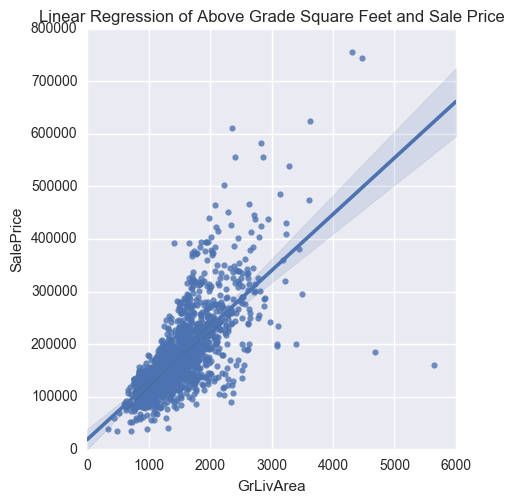

In [6]:
sns.lmplot(x="GrLivArea", y="SalePrice", data=wholedf);
plt.title("Linear Regression of Above Grade Square Feet and Sale Price")
plt.ylim(0,)
plt.show()

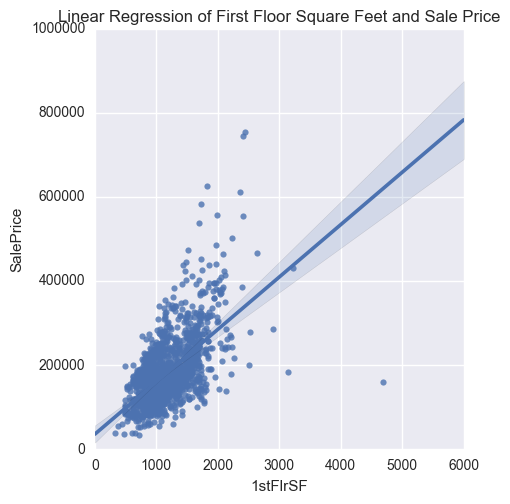

In [7]:
sns.lmplot(x="1stFlrSF", y="SalePrice", data=wholedf);
plt.title("Linear Regression of First Floor Square Feet and Sale Price")
plt.ylim(0,)
plt.show()

Correlation
--------------
A quick correlation check is the best way to the heart of the data set.  There is a far amount of correlation for sales price with a couple of variables:

* OverallQual - 0.790982
* GrLivArea -  0.708624
* GarageCars -  0.640409
* GarageArea -  0.623431
* TotalBsmtSF -  0.613581
* 1stFlrSF -  0.605852
* FullBath -  0.560664
* TotRmsAbvGrd -  0.533723
* YearBuilt  - 0.522897
* YearRemodAdd -  0.507101


In [8]:
traincorr = traindf.corr()['SalePrice']
# convert series to dataframe so it can be sorted
traincorr = pd.DataFrame(traincorr)
# correct column label from SalePrice to correlation
traincorr.columns = ["Correlation"]
# sort correlation
traincorr2 = traincorr.sort_values(by=['Correlation'], ascending=False)
traincorr2.head(15)

,Correlation
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


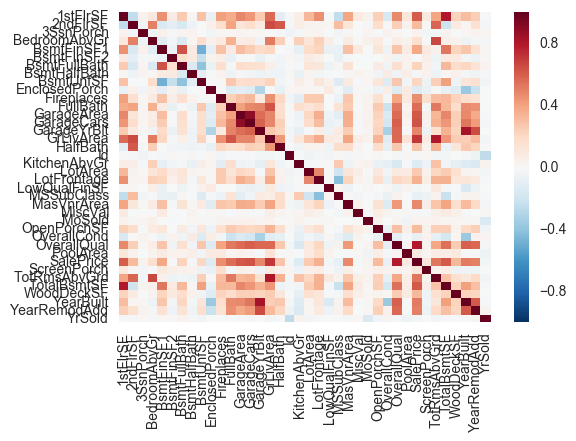

In [9]:
corr = wholedf.corr()
sns.heatmap(corr)
plt.show()

Missing Values
--------------------
There is a wide selection of missing values. First it make sense to hit the low hanging fruit first and deal with those that are missing a value or two, then work through what is left. Some of these look to be missing values not because they don’t have data but rather because the building was missing that feature, like a garage. Using Pandas Get.Dummies will sort that problem out into true/false values

In [10]:
countmissing = wholedf.isnull().sum().sort_values(ascending=False)
percentmissing = (wholedf.isnull().sum()/wholedf.isnull().count()).sort_values(ascending=False)
wholena = pd.concat([countmissing,percentmissing], axis=1)
wholena.head(36)

,0,1
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471


Replacing Missing Data
------------
For the categorical information that is missing a single values a quick check shows which ones are dominant and manually replace the missing values. For most it is a quick process, I commented out the Python as I had in order to keep this shorter but feel free to uncomment and take a look.

In [11]:
#wholedf[["Utilities", "Id"]].groupby(['Utilities'], as_index=False).count()
wholedf['Utilities'] = wholedf['Utilities'].fillna("AllPub")

# wholedf[["Electrical", "Id"]].groupby(['Electrical'], as_index=False).count()
wholedf['Electrical'] = wholedf['Electrical'].fillna("SBrkr")

# wholedf[["Exterior1st", "Id"]].groupby(['Exterior1st'], as_index=False).count()
wholedf['Exterior1st'] = wholedf['Exterior1st'].fillna("VinylSd")

#wholedf[["Exterior2nd", "Id"]].groupby(['Exterior2nd'], as_index=False).count()
wholedf['Exterior2nd'] = wholedf['Exterior2nd'].fillna("VinylSd")

In [12]:
# Missing interger values replace with the median in order to return an integer
wholedf['BsmtFullBath']= wholedf.BsmtFullBath.fillna(wholedf.BsmtFullBath.median())
wholedf['BsmtHalfBath']= wholedf.BsmtHalfBath.fillna(wholedf.BsmtHalfBath.median())
wholedf['GarageCars']= wholedf.GarageCars.fillna(wholedf.GarageCars.median())

# Missing float values were replaced with the mean for accuracy 
wholedf['BsmtUnfSF']= wholedf.BsmtUnfSF.fillna(wholedf.BsmtUnfSF.mean())
wholedf['BsmtFinSF2']= wholedf.BsmtFinSF2.fillna(wholedf.BsmtFinSF2.mean())
wholedf['BsmtFinSF1']= wholedf.BsmtFinSF1.fillna(wholedf.BsmtFinSF1.mean())
wholedf['GarageArea']= wholedf.GarageArea.fillna(wholedf.GarageArea.mean())
wholedf['MasVnrArea']= wholedf.MasVnrArea.fillna(wholedf.MasVnrArea.mean())

### Infer Missing Values
Some of the missing values can be inferred from other values for that given property. The GarageYearBuilt would have to be at the earliest the year the house was built. Likewise TotalBasementSQFeet would have to be equal to the first floor square footage.

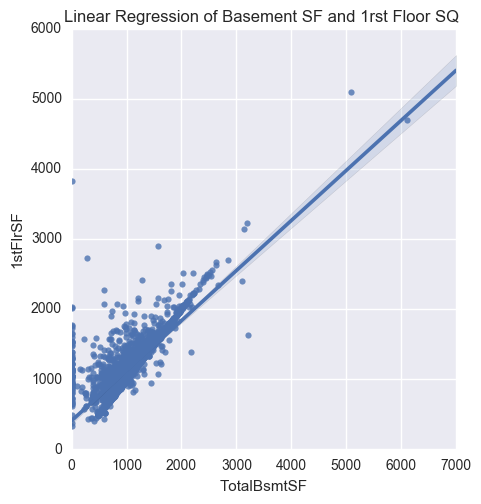

In [13]:
wholedf.GarageYrBlt.fillna(wholedf.YearBuilt, inplace=True)
wholedf.TotalBsmtSF.fillna(wholedf['1stFlrSF'], inplace=True)

sns.lmplot(x="TotalBsmtSF", y="1stFlrSF", data=wholedf)
plt.title("Linear Regression of Basement SF and 1rst Floor SQ ")
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Lot Frontage

Lot Frontage is a bit trickier. There are 486 missing values (17% of total values) but a quick check of correlation shows that there are surprisingly few features that have high correlation outside of Lot Area.

In [14]:
lot = wholedf[['LotArea','LotConfig','LotFrontage','LotShape']]
lot = pd.get_dummies(lot)
lot.corr()['LotFrontage']

LotArea              0.489896
LotFrontage          1.000000
LotConfig_Corner     0.257028
LotConfig_CulDSac   -0.104612
LotConfig_FR2       -0.056992
LotConfig_FR3        0.027509
LotConfig_Inside    -0.162484
LotShape_IR1         0.151502
LotShape_IR2        -0.011356
LotShape_IR3         0.139550
LotShape_Reg        -0.164639
Name: LotFrontage, dtype: float64

Logic dictates that the Lot Area should have a linear relation to Lot Frontage. A quick check with a linear regression of the relationship between Lot Frontage and the square root of Lot Area (or effectively one side) shows we are in the ballpark.

In [15]:
lot["LotAreaUnSq"] = np.sqrt(lot['LotArea'])

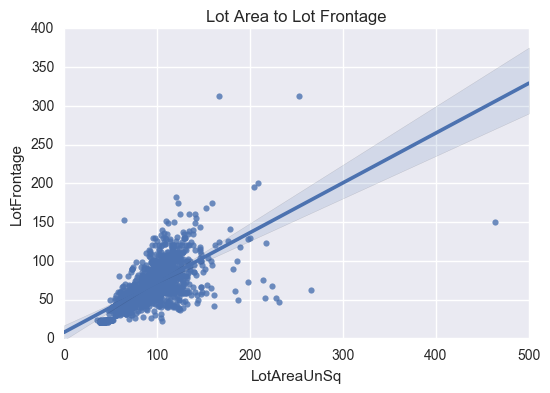

In [16]:
sns.regplot(x="LotAreaUnSq", y="LotFrontage", data=lot);
plt.xlim(0,)
plt.ylim(0,)
plt.title("Lot Area to Lot Frontage")
plt.show()

In [17]:
# Remove all lotfrontage is missing values
lot = lot[lot['LotFrontage'].notnull()]
# See the not null values of LotFrontage
lot.describe()['LotFrontage']

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [18]:
wholedf['LotFrontage']= wholedf.LotFrontage.fillna(np.sqrt(wholedf.LotArea))
wholedf['LotFrontage']= wholedf['LotFrontage'].astype(int)

Once the missing values are filled in, it is good to confirm that the distribution did not go way out of wack. The blue is the original distribution, the green is the new one with missing values inferred and the red is the curve of the square root of lot area. I looks like a majority of these properties unsurprisingly do not have perfectly square lots but for our purposes, everything looks good.

C:\Users\kefor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


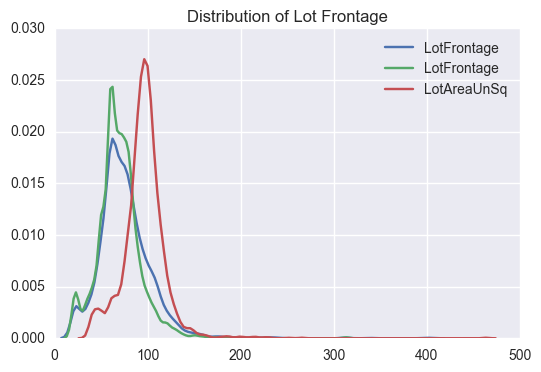

In [19]:
# Distribution of values after replacement of missing frontage
sns.kdeplot(wholedf['LotFrontage']);
sns.kdeplot(lot['LotFrontage']);
sns.kdeplot(lot['LotAreaUnSq']);
plt.title("Distribution of Lot Frontage")
plt.show()

In [20]:
countmissing = wholedf.isnull().sum().sort_values(ascending=False)
percentmissing = (wholedf.isnull().sum()/wholedf.isnull().count()).sort_values(ascending=False)
wholena = pd.concat([countmissing,percentmissing], axis=1)
wholena.head(3)

,0,1
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169


## Feaure Engineering
-----------------------
Now it is time to create some new features and see how they can help the model’s accuracy. First are a couple of macro creations, like adding all the internal and external square footage together to get the total living space including both floors, garage and external spaces.

In [21]:
Livingtotalsq = wholedf['TotalBsmtSF'] + wholedf['1stFlrSF'] + wholedf['2ndFlrSF'] + wholedf['GarageArea'] + wholedf['WoodDeckSF'] + wholedf['OpenPorchSF']
wholedf['LivingTotalSF'] = Livingtotalsq

# Total Living Area divided by LotArea
wholedf['PercentSQtoLot'] = wholedf['LivingTotalSF'] / wholedf['LotArea']

# Total count of all bathrooms including full and half through the entire building
wholedf['TotalBaths'] = wholedf['BsmtFullBath'] + wholedf['BsmtHalfBath'] + wholedf['HalfBath'] + wholedf['FullBath']

# Percentage of total rooms are bedrooms
wholedf['PercentBedrmtoRooms'] = wholedf['BedroomAbvGr'] / wholedf['TotRmsAbvGrd']

# Number of years since last remodel, if there never was one it would be since it was built
wholedf['YearSinceRemodel'] = 2016 - ((wholedf['YearRemodAdd'] - wholedf['YearBuilt']) + wholedf['YearBuilt'])

## Total Square Footage
There is a minimal increase of the Condition Rating to square foot, which is not a surprise. However when a linear regression with the Sale Price is taken instead a much more obvious pattern emerges.

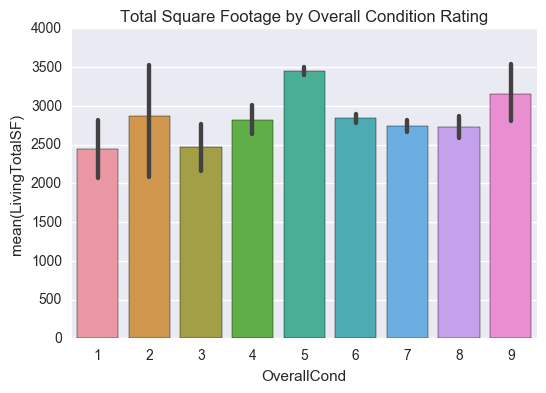

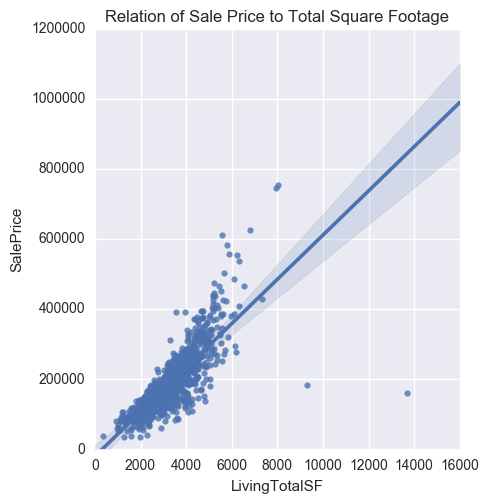

In [33]:
sns.barplot(x="OverallCond", y="LivingTotalSF", data=wholedf)
plt.title("Total Square Footage by Overall Condition Rating")
plt.show()

sns.lmplot(x="LivingTotalSF", y="SalePrice", data=wholedf)
plt.title("Relation of Sale Price to Total Square Footage")
plt.xlim(0,)
plt.ylim(0,)
plt.show()

## Total Rooms
Conversely if rooms were what interested you, there is a pronounced relationship between rooms and the number of bathrooms. This is the mean of bathrooms and the line is the variance (how much from the average most values deviate).

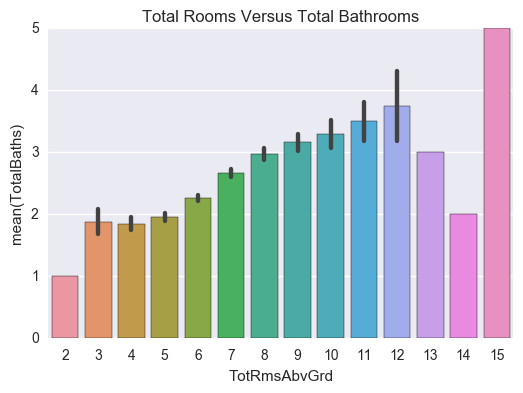

In [23]:
ax = sns.barplot(x="TotRmsAbvGrd", y="TotalBaths",data=wholedf)
plt.title("Total Rooms Versus Total Bathrooms")
plt.show()

## Sale Month
Once last colorful graph before wrapping this up. I have wondered this about the Vermont housing market as the weather can have a large impact on many activities, including looking at houses I would imagine.

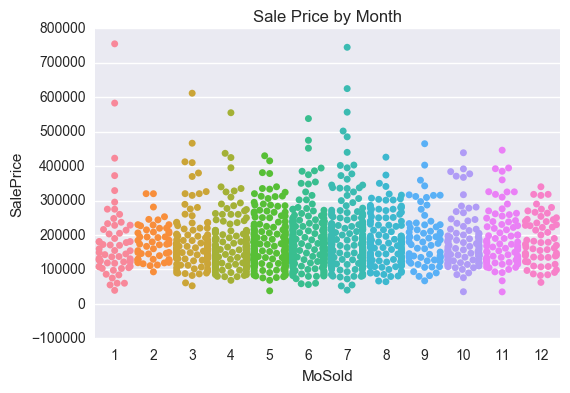

C:\Users\kefor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


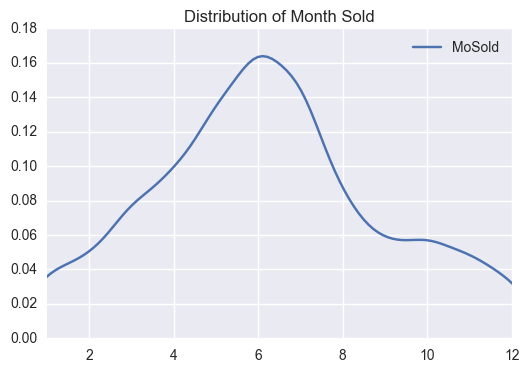

In [36]:
sns.swarmplot(x="MoSold", y="SalePrice", data=wholedf)
plt.title("Sale Price by Month")
plt.show()

sns.kdeplot(wholedf['MoSold']);
plt.title("Distribution of Month Sold")
plt.xlim(1,12)
plt.show()

## Neighborhoods
All of us know that neighborhoods have a wide variety of characteristics. In some ways there is a relationship to sale price, but it is harder to define and less useful in prediction.

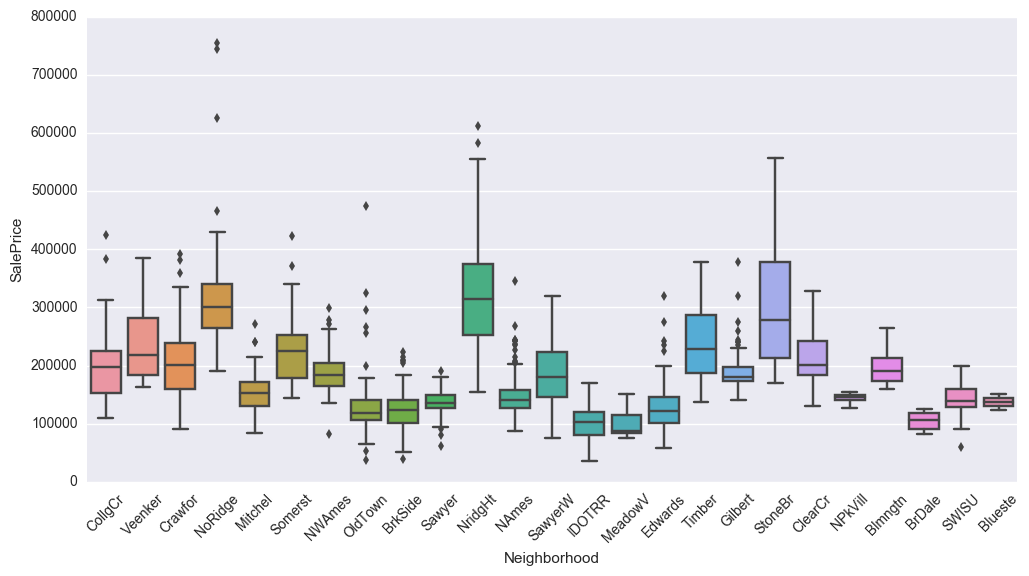

In [38]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = wholedf)
plt.xticks(rotation=45)
plt.show()


### Features
This is a way to edit what feeatures are included in the final model.  I played a bit with which to include, and I have a feeling I may come back to this to re-engineer it.  

In [39]:
pricing1 = wholedf[['Id','SalePrice','MiscVal']]

neigh = wholedf[['Neighborhood','MSZoning','MSSubClass','BldgType','HouseStyle']]

dates = wholedf[['YearBuilt','YearRemodAdd','GarageYrBlt','YearSinceRemodel']]

quacon = wholedf[['ExterQual','BsmtQual','PoolQC','Condition1','Condition2','SaleCondition',
                  'BsmtCond','ExterCond','GarageCond','KitchenQual','GarageQual','HeatingQC','OverallQual','OverallCond']]

features =  wholedf[['Foundation','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                     'MiscFeature','PavedDrive','Utilities',
                     'Heating','CentralAir','Electrical','Fence']]

sqfoot = wholedf[['LivingTotalSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
                  'GarageArea','WoodDeckSF','OpenPorchSF','LotArea','PercentSQtoLot','LowQualFinSF']]

roomfeatcount = wholedf[['PercentBedrmtoRooms','TotalBaths','FullBath','HalfBath',
                         'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageType','EnclosedPorch']]

# Splits out sale price for the training set and only has not null values
pricing = wholedf['SalePrice']
pricing = pricing[pricing.notnull()]

# Bringing it all together
wholedf = pd.concat([pricing1,neigh,dates,quacon,features,sqfoot,roomfeatcount], axis=1)

### Categorical Conversion
In order for the model to understand categories, first replace all the categorical data with boolean values through Pandas get_dummies.  

In [40]:
wholedf = pd.get_dummies(wholedf)

In [46]:
traincorr = wholedf.corr()['SalePrice']
# convert series to dataframe so it can be sorted
traincorr = pd.DataFrame(traincorr)
# correct column label from SalePrice to correlation
traincorr.columns = ["Correlation"]
# sort correlation
traincorr2 = traincorr.sort_values(by=['Correlation'], ascending=False)
traincorr2.head(15)

,Correlation
SalePrice,1.000000
LivingTotalSF,0.815688
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
TotalBaths,0.613005
1stFlrSF,0.605852
FullBath,0.560664


## Split Database
--------
Time to split the database back into two parts, one with sales price and one without

In [41]:
train_X = wholedf[wholedf['SalePrice'].notnull()]
del train_X['SalePrice']
test_X =  wholedf[wholedf['SalePrice'].isnull()]
del test_X['SalePrice']

## Training/Test Dataset

Create training set assembly

In [42]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = train_X
train_valid_y = pricing
test_X = test_X
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

## Model
Here are a variety of models you can try, many performed extremely poorly, Lasso was the best but I plan to go back to this and do further work on refining my features, like log regressions and normalizations.  

In [43]:
# model = RandomForestRegressor()
model = Ridge()
# model = LassoLarsCV()

# Models that performed substantially worse
# model = LinearSVC()
# model = KNeighborsClassifier(n_neighbors = 3)
# model = GaussianNB()
# model = LogisticRegression()
# model = SVC()

## Fit/Accurancy

In [44]:
model.fit( train_X , train_y )

# Print the Training Set Accuracy and the Test Set Accuracy in order to understand overfitting
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.909540984343 0.870088318545


In [45]:
id = test_X.Id
result = model.predict(test_X)

# output = pd.DataFrame( { 'id': id , 'SalePrice': result}, columns=['id', 'SalePrice'] )
output = pd.DataFrame( { 'id': id , 'SalePrice': result} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,107027.556110
1,1462,166378.271402
2,1463,169611.042818
3,1464,192110.375211
4,1465,213212.551711
5,1466,173813.324413
6,1467,175924.242843
7,1468,165169.383555
8,1469,190098.900626
9,1470,122357.316718


## Conclusion

There were a couple of models tried. Random Forest Regression, LassoLarsCV and Ridge were all options and after experimenting I ended up settling on Ridge as the better option. What was fascinating and frustrating was the wide variation in accuracy each time I ran it. The models all seem to have some fluctuation in them. In the end I had about a 82%–90% accuracy. In trying to apply this same process to Burlington’s housing data I ran into even stranger inconsistency and huge over fitting problems.  I have a feeling this will be a work in progress as I try it on other data sets.  

There were some great kernels out there that helped me work through the problem, definately check the following out:
https://www.kaggle.com/neviadomski/house-prices-advanced-regression-techniques/how-to-get-to-top-25-with-simple-model-sklearn
https://www.kaggle.com/poonaml/house-prices-advanced-regression-techniques/house-prices-data-exploration-and-visualisation
https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
https://www.kaggle.com/xchmiao/house-prices-advanced-regression-techniques/detailed-data-exploration-in-python

